## Meta Analysis

### 1. Create Dataset
If you already have a dataset, you do not have to follow this section, we are going to show how the simulation will be done.

In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('pwd'))))))

In [3]:

import pandas as pd
import numpy as np
def seed_everything(seed):
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.enabled = False
    # torch.use_deterministic_algorithms(True)



seed=1337
seed_everything(seed)

In [4]:
import argparse
parser = argparse.ArgumentParser(description='Args Sparse Simulation')
parser.add_argument('--p_num', type=int, default=10, help='num ber of permutation')
parser.add_argument('--x_grid_start',type=int, default=1,help='start of the x-axis')
parser.add_argument('--x_grid_end',type=int, default=20,help='end of the x-axis')
parser.add_argument('--same_ratio',type=int, default=90,help='Difference ratio for each group') ## only can choose 50,90, 100
parser.add_argument('--interval',type=float,default=0.1,help='interval for x-axis' )
parser.add_argument('--epsilon',type=float,default=0.0001,help='to_avoid zero division')
args, _ = parser.parse_known_args()

# please decrease the ratio of the first half by 0.5 and increase the ratio for decreased amount to the second half
beta=0.7
# randomly select the number of microiomes to change the ratio
num_microbiomes_to_change=200
# sort
sort_option=False



otu=pd.read_csv("throatotu_csv.csv")

otu['x']
# drop three most abundant species

#sort 
otu=otu.sort_values(by='x',ascending=False)
otu=otu.iloc[3:]



# divide by sum of the row
ratio=otu['x']/otu['x'].sum()


# randomly select the microbiomes to change the ratio
ratio=ratio.to_numpy()
if sort_option ==False:
    # sort ratio
    np.random.shuffle(ratio)




ratio_to_change=ratio[:num_microbiomes_to_change]
ratio_to_change
ratio_fixed=ratio[num_microbiomes_to_change:]

decreased=ratio_to_change[:int(len(ratio_to_change)/2)]-ratio_to_change[:int(len(ratio_to_change)/2)]*beta

ratio_change_first_half=ratio[:int(len(ratio_to_change)/2)]-decreased
ratio_second_half=ratio_to_change[int(len(ratio_to_change)/2):]
increased=np.zeros(len(ratio_second_half))
sum_ratio_second_half=ratio_second_half.sum()   

for i in range(len(ratio_second_half)):

    increased[i]=(decreased.sum()*ratio_second_half[i])/sum_ratio_second_half
# distribute the increased ratio to the second half with equivalent to 

ratio_second_half=ratio_to_change[int(len(ratio_to_change)/2):]+increased

g1_param=ratio
g_changed=np.concatenate([ratio_change_first_half,ratio_second_half])
g2_param=np.concatenate([g_changed,ratio_fixed])


Now, the parameters for generating samples for each group have been made. 
for g1, and g2 , Now using dirichlet distribution, we try to generate samples. 
We have to choose overdispersion parameter $\theta$ 


In [5]:
theta=0.0001 # overdispersion parameter
num_samples=50 # number of samples.  this will be a major paramter. 

g1=np.random.dirichlet(g1_param*(1/theta),size=1)
g2=np.random.dirichlet(g2_param*(1/theta), size=1)
# s
#create count poisson
g1_count_total=np.random.poisson(10000.0,num_samples)
g2_count_total=np.random.poisson(10000.0,num_samples)

#what i watn to do is get dividing rowwise summation
# g1_normalized = g1_count / g1_count.sum(axis=1)[:, np.newaxis]
# g2_normalized = g2_count / g2_count.sum(axis=1)[:, np.newaxis]
g1_count=np.zeros((num_samples,len(g1_param)))
g2_count=np.zeros((num_samples,len(g2_param)))

for i in range(num_samples):
    g1_count[i]=np.random.multinomial(g1_count_total[i],g1[0])
    g2_count[i]=np.random.multinomial(g2_count_total[i],g2[0])

g1_normalized = g1_count / g1_count.sum(axis=1)[:, np.newaxis]
g2_normalized = g2_count / g2_count.sum(axis=1)[:, np.newaxis]

epsilon = 1e-10  # Small constant to avoid log(0)
g1_entropy = np.where(g1_normalized > 0.0001, -np.log(g1_normalized ), 0)
g2_entropy = np.where(g2_normalized > 0.0001, -np.log(g2_normalized ), 0)

g1_entropy = g1_entropy.T
g2_entropy = g2_entropy.T

In [6]:
for i in range(num_samples):
    g1_count[i]=np.random.multinomial(g1_count_total[i],g1[0])
    g2_count[i]=np.random.multinomial(g2_count_total[i],g2[0])

g1_normalized = g1_count / g1_count.sum(axis=1)[:, np.newaxis]
g2_normalized = g2_count / g2_count.sum(axis=1)[:, np.newaxis]



### 2. Finding bandwidth for each feature
then, you select one group to find some relationship between standard deviation that data itself have. 
by calling the function ```finddistribution```, you can obtain the bandwidth for each feature. 

In [10]:
from src.Grouping import Groupinfo
x_grid=np.arange(0,15,0.1)
feat_info=np.zeros(g1_entropy.shape[0])
feat_info+=1 ## as this is simulated  case, you cannot consider the prior-posterior case. 
t1=Groupinfo(g1_entropy)
t1.finddistribution(x_grid,epsilon=0.0001,feat_info=feat_info)

then by using the defined functions, you can get the sigma and bandwidth for the generated case. 

In [11]:
bw=np.array(t1.group_bandwidth)
sig=np.sqrt(np.array(t1.getsigma()))
from matplotlib import pyplot as plt

In [12]:
bw

array([0.5, 8.9, 0. , 0. , 0. , 1.9, 3.9, 0. , 0.7, 8.9, 0.7, 8.9, 0.5,
       0. , 0.1, 8.9, 1.4, 1.3, 0.1, 2.8, 0.8, 0.6, 0.5, 0.1, 0.9, 0.9,
       1.3, 1.9, 0.5, 8.9, 0.5, 0.8, 0.3, 8.9, 2.4, 0.7, 0. , 1.5, 0.8,
       0.8, 8.9, 1.4, 0.1, 0.8, 0.8, 0.1, 0. , 5.5, 0.7, 8.9, 0.8, 2.3,
       0.8, 0. , 2.8, 1.1, 8.9, 8.9, 0.2, 0. , 2.5, 8.9, 8.6, 0.8, 2.2,
       1.2, 1. , 1.9, 0.1, 0.8, 0.8, 0. , 0.1, 8.9, 0. , 0. , 1.3, 0.7,
       4.7, 0.1, 0.7, 0.8, 0.9, 0.8, 2.8, 0.7, 0. , 0. , 0.1, 1.7, 0.8,
       0. , 0. , 1.1, 2.7, 0. , 0.9, 0. , 1.2, 8.9, 0.2, 0.7, 1.4, 0.6,
       8.9, 0.8, 1.2, 1.3, 1.6, 0. , 0. , 0.9, 0. , 0.1, 0.1, 1.1, 1.1,
       0. , 0.7, 0.5, 8.3, 0.1, 0.8, 1.7, 0. , 0.6, 0.8, 0.1, 0.1, 0. ,
       0.1, 0.7, 0.4, 8.9, 4.8, 0. , 1. , 8.8, 0.1, 8.9, 1.5, 0.8, 0. ,
       8.9, 8.9, 0.1, 0.7, 4.2, 0.7, 0.5, 8.9, 0.1, 3.2, 0.1, 0.1, 0. ,
       3.6, 1. , 0.6, 0.4, 0.5, 1.5, 8.9, 1.1, 1.8, 2.9, 0. , 0.8, 0. ,
       4.7, 0. , 0. , 1.2, 0.1, 2.4, 0. , 0.8, 1.1, 1.9, 0.1, 0.

this is a scatter of randomly generated data

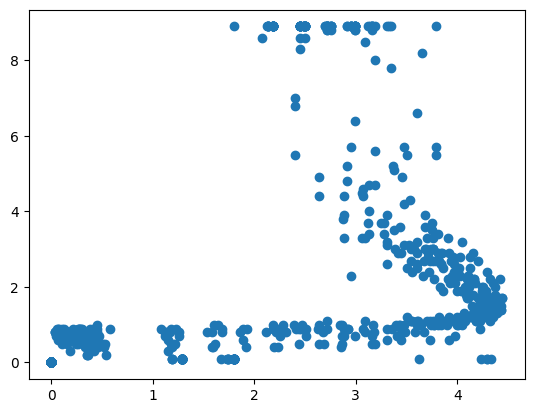

In [13]:
plt.scatter(sig,bw)

now based on the plot's structure you can eiter fit log or polynomial regression to the data. 

In [20]:
model = np.poly1d(np.polyfit(sig, bw, 1))
coef=model.coefficients
x_grid=np.arange(0,5,0.1)

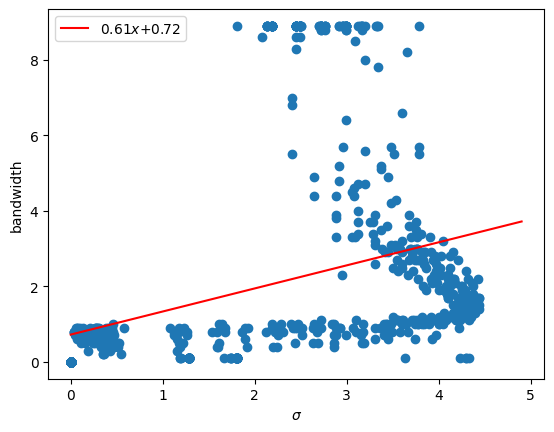

In [22]:
plt.scatter(sig,bw)
plt.xlabel('$\sigma$')
plt.ylabel('bandwidth')
#plt.plot(x_grid,((x_grid**2)*coef[0]+(x_grid)*coef[1]+coef[2]),color='r',label='${}x^2$${}x$+{}'.format(round(coef[0],2),round(coef[1],2),round(coef[2],2)))
#polyfit linear plot
plt.plot(x_grid,(x_grid)*coef[0]+coef[1],color='r',label='${}x$+{}'.format(round(coef[0],2),round(coef[1],2)))
plt.legend()

In [23]:
n50_bw=bw
n50_sigma=sig

# save as dataframe
n50_df=pd.DataFrame({'bandwidth':n50_bw,'sigma':n50_sigma})
n50_df.to_csv('n50_df.csv',index=False)

